**Imports:**

In [1]:
from types import SimpleNamespace
from copy import deepcopy

import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

import ipywidgets as widgets

$$
\begin{align}
v(p,w,M,\overline{L}) &=\max_{L\in[0,\overline{L}]}\ln\left(\frac{M+W(L)}{p}\right)-\nu\frac{L^{1+\frac{1}{\epsilon}}}{1+\frac{1}{\epsilon}} \\
&=\max_{L\in\{0,\frac{w}{\kappa},\overline{L}\}\cup(0,\frac{w}{\kappa})\cup(\frac{w}{\kappa},\overline{L})}\ln\left(\frac{W(L)+M}{p}\right)-\nu\frac{L^{1+\frac{1}{\epsilon}}}{1+\frac{1}{\epsilon}}
\end{align}
$$

# Functions

**Basic functions:**

In [2]:
def W_func(L,par):
    """ wage W as function of labour supply L """
    
    return (1-par.tau_0)*par.w*L - par.tau_1*np.fmax(par.w*L-par.kappa,0.0)

def W_prime_func(L,par):
    """ marginal wage W as function of labour supply L """
    
    if L < par.kappa/par.w:
        return (1-par.tau_0)*par.w
    else:
        return (1-par.tau_0-par.tau_1)*par.w

def utility(L,par):
    """ utility as function of labor supply L with maximum consumption """

    C = W_func(L,par) + par.M
    return np.log(C) - par.nu*L**(1+1/par.epsilon)/(1+1/par.epsilon)

def FOC(L,par):
    """ error in first order condition (FOC) given labor supply"""
    
    # a. LHS
    LHS = L
    
    # b. RHS
    marginal_real_wage = W_prime_func(L,par)/par.p
    marginal_utility = 1/((W_func(L,par)+par.M)/par.p)
    RHS = (1.0/par.nu*marginal_real_wage*marginal_utility)**par.epsilon
    
    # c. error
    return LHS-RHS

**Solve problem:**

In [3]:
def solve(par,do_print=False):

    # a. L = 0.0
    u0 = utility(0.0,par)
    
    # b. L = Lmax
    umax = utility(par.Lmax,par)
    
    # c. L = kappa/w
    L_mid = par.kappa/par.w
    umid = utility(L_mid,par)
    
    # d. left interval
    sign_LL = np.sign(FOC(1e-8,par))
    sign_LR = np.sign(FOC(L_mid-1e-8,par))
    
    if not sign_LL == sign_LR:
        sol_L = optimize.bisect(FOC,1e-8,L_mid-1e-8,args=(par,))
        uL = utility(sol_L,par)
    else:
        sol_L = np.nan
        uL = np.nan
        
    # e. right interval
    sign_RL = np.sign(FOC(L_mid+1e-8,par))
    sign_RR = np.sign(FOC(par.Lmax-1e-8,par))
    
    if not sign_RL == sign_RR:
        sol_R = optimize.bisect(FOC,L_mid+1e-8,par.Lmax-1e-8,args=(par,))
        uR = utility(sol_R,par)
    else:
        sol_R = np.nan       
        uR = np.nan
    
    # f. global maksimum
    i_opt = np.nanargmax([u0,uL,umid,uR,umax])
    
    if i_opt == 0:
        L_opt = 0.0
    elif i_opt == 1:
        L_opt = sol_L
    elif i_opt == 2:
        L_opt = L_mid
    elif i_opt == 3:
        L_opt = sol_R
    elif i_opt == 4:
        L_opt = par.Lmax
        
    return L_opt

**Plotting function:**

In [4]:
def plot_solutions(pars,names,w_low=0.1,w_high=30,Nw=200):
    """ plot solution for different wage levels """
        
    fig = plt.figure(figsize=(6,18/1.5),dpi=100)
    ax1 = fig.add_subplot(3,1,1)
    ax2 = fig.add_subplot(3,1,2)
    ax3 = fig.add_subplot(3,1,3)
    
    for j,(par,name) in enumerate(zip(pars,names)):
        
        w_orig = par.w # for later reset

        # a. solve
        w_vec = np.linspace(w_low,w_high,Nw)
        L_vec = np.zeros(w_vec.shape)
        C_vec = np.zeros(w_vec.shape)
        for i,w in enumerate(w_vec):
            par.w = w
            L_vec[i] = solve(par)
            C_vec[i] = W_func(L_vec[i],par) + par.M
        
        # b. plot
        ax1.plot(w_vec,L_vec,label=name,color=colors[j])
        ax2.plot(w_vec,w_vec*L_vec,label=name,color=colors[j])      
        ax2.axhline(par.kappa,ls='--',label=f'$\kappa = {par.kappa}$',color=colors[j])      
        ax3.plot(w_vec,C_vec,label=name,color=colors[j])

        # c. reset
        par.w = w_orig
        
    ax1.set_title('Labor supply: $L$')
    ax1.legend(frameon=True)
    ax1.set_xlabel('$w$')
    ax1.set_ylabel('$L$')

    ax2.set_title('Pre-tax labor income: : $w*L$')
    ax2.legend(frameon=True)
    ax2.set_xlabel('$w$')
    ax2.set_ylabel('$w*L$')
    
    ax3.set_title('Consumption: : $C = W(L) + M$')
    ax3.legend(frameon=True)
    ax3.set_xlabel('$w$')
    ax3.set_ylabel('$C$')
    
    fig.tight_layout(pad=1.0)
    

# Solve

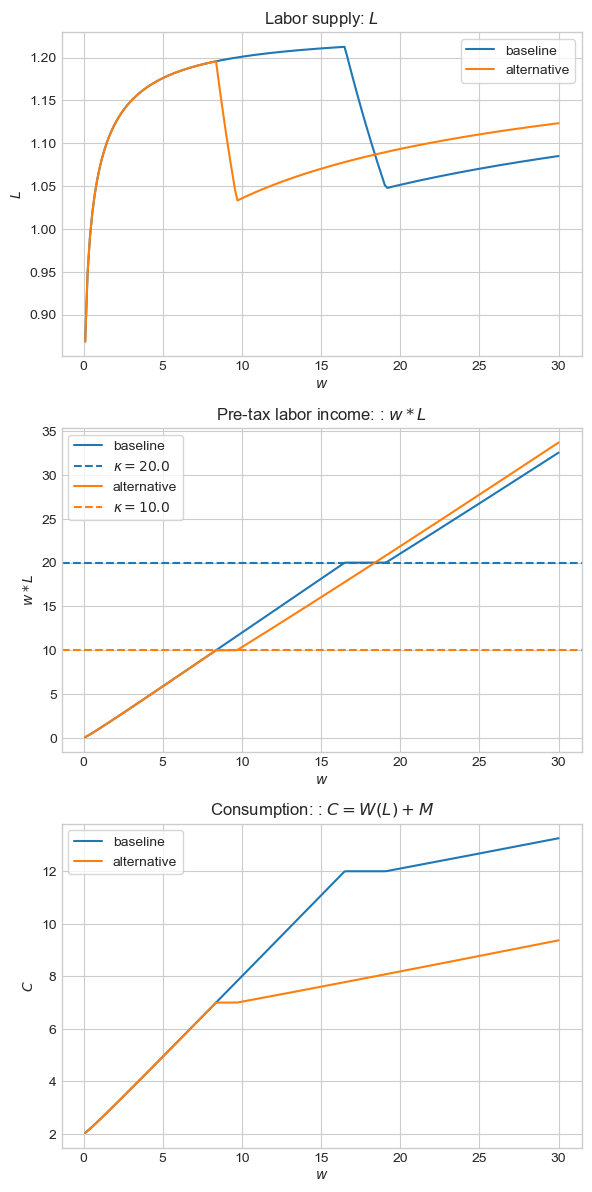

In [5]:
par = SimpleNamespace()

# utility 
par.epsilon = 0.1
par.nu = 0.1

# income
par.M = 2.0
par.Lmax = 2.0

# numeraire
par.p = 1.0

# taxes
par.tau_0 = 0.5
par.tau_1 = 0.4
par.kappa = 20.0

par.w = np.nan

# alternative
par_alt = deepcopy(par)
par_alt.kappa = 10.0

plot_solutions([par,par_alt],['baseline','alternative'])